# 01 - Preprocessing
>Generate a word cloud based on the raw corpus -- I recommend you to use the Python word_cloud library. With the help of nltk (already available in your Anaconda environment), implement a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and cons (if any) of the two word clouds you generated.

In [1]:
import pandas as pd
import numpy as np
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import nltk.sentiment.util
import gensim
%matplotlib inline
%load_ext autoreload
%autoreload 2


/home/thomas/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/thomas/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## 1. Loading the emails and retrieving the raw text
Let us first load the DataFrame and see a bit what we're dealing with.

In [2]:
email_df = pd.read_csv("hillary-clinton-emails/Emails.csv")

Before going any further, let us a bit explore those emails, so we know a bit more what we're working with. We see below how many emails there are and what are the fields that we can find in the DataFrame.

In [3]:
print(email_df.shape)
print(email_df.columns)
email_df.head()

(7945, 22)
Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


The text we're interested in is mostly in two fields of this large *emails.csv* file. It is in the `ExtractedSubject` and `ExtractedBodyText` columns. We first tried with merging these two fields together, but it worked better while only considering the `ExtractedBodyText` fields, which we did for this last try. Indeed, the extracted subject contains oftenthe same words, as they are email titles, and repeats itself along a conversation. It adds a lot of words which are not very useful for determining the perception of a country or doing topic modelling. This is why we choose to work only with the extracted subject. We replace the `NaN` with empty string in order not to lose the information that there is a link between the two persons who sent/received the email, because this information will be useful later on.

In [4]:
email_df['Text'] = email_df['ExtractedBodyText'].fillna('')
email_text = list(email_df['Text'])

`Wordcloud` needs to have a string as an entry, we first need to merge our list into a single string, then we will be able to display the wordcloud of Hillary Clinton's emails, taking the raw text of the mails.

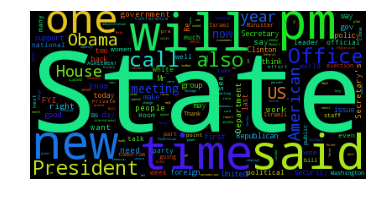

In [5]:
#Merging everything into one big chunk of text.
emails_str = ' '.join(email_text)
wordcloud = WordCloud().generate(emails_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

A lot of the words displayed are not very *relevant* to the understanding of the contents of the emails, and are not filtered as they are specific to the email vocabulary. We should manually remove words like *Re*, *Fw*, or even other relatively meaningless words like *pm*, *new*, *also*, ... in order to obtain something more representative from the content of the emails. This is what we will do now with a text preprocessing pipeling.

## 2. Preprocessing pipeline

### a. Tokenization 
We choose to use the *WordPunctTokenizer*, because what it does
> Tokenize a text into a sequence of alphabetic and non-alphabetic characters, using the regexp `\w+|[^\w\s]+`.

You can see below how it splits the data into words, numbers and leaves expressions like **.**,**,**,**:** on their own string. The next step will be simply to remove those, as they do not provide any useful information on the data. We will also remove all the numeral expression. 

In [6]:
from nltk.tokenize import WordPunctTokenizer

email_text_processed_token = [WordPunctTokenizer().tokenize(email) for email in email_text]

In [7]:
print(email_text[0:3])
print(email_text_processed_token[0:3])

['', 'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary', 'Thx']
[[], ['B6', 'Thursday', ',', 'March', '3', ',', '2011', '9', ':', '45', 'PM', 'H', ':', 'Latest', 'How', 'Syria', 'is', 'aiding', 'Qaddafi', 'and', 'more', '...', 'Sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311', '.', 'docx', ';', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311', '.', 'docx', 'March', '3', ',', '2011', 'For', ':', 'Hillary'], ['Thx']]


We see that we still have to remove the numbers and punctuation. To this end, we will use the very useful `isalpha()` function, which 
>returns true if all characters in the string are alphabetic and there is at least one character, false otherwise.

In [8]:
email_text_processed_token = [[word.lower() for word in email if word.isalpha()]
                        for email in email_text_processed_token]

print(email_text[0:3])
print(email_text_processed_token[0:3])

['', 'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary', 'Thx']
[[], ['thursday', 'march', 'pm', 'h', 'latest', 'how', 'syria', 'is', 'aiding', 'qaddafi', 'and', 'more', 'sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'march', 'for', 'hillary'], ['thx']]


We got the desired tokenization of our data. We now have to remove all the stop words from the text.

### b. Stopwords removal

In order to remove all the common words from our text, we load a *stopwords* dictionary, to which we'll add our custom stop words, especially considering : *fw*, *re*, *pm* and other things like that. This will be an iterative process, and what we will show below will be the dictionary resulting from this iterative process, with all the words we though should be filtered. 

Note that it is necessary to download the *stopwords* dictionaries in order to make them available.

In [9]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We check out the common words in english, just below, that we will remove from our email. We add also our custom stop words here.

In [10]:
stop_list = ['re','fw','h','pm','docx']
stop_list.extend(stopwords.words('english'))
print(stop_list)

['re', 'fw', 'h', 'pm', 'docx', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will

Let us now remove those stop words from our email corpus. 

In [11]:
email_text_processed = [[word for word in email if word not in stop_list]
                        for email in email_text_processed_token]

The result below shows that words like *FW*, numbers and common words have been remove, which is what we wanted.

In [12]:
print(email_text[0:3])
print(email_text_processed[0:3])

['', 'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary', 'Thx']
[[], ['thursday', 'march', 'latest', 'syria', 'aiding', 'qaddafi', 'sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'march', 'hillary'], ['thx']]


Before moving on to the last step of our preprocessing, namely the stemming, we want to display an intermediary word cloud, to see whether this processing improved the "quality" of the word cloud. 

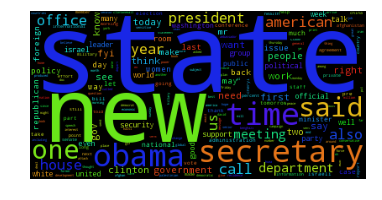

In [13]:
#Merging everything into one big chunk of text.
emails_str = ' '.join([' '.join(email) for email in email_text_processed])
wordcloud = WordCloud().generate(emails_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

There are many improvements for this word cloud, compared to the previous one. First of all, we removed a lot of meaningless words, which were omnipresent in the emails (the *Re:*, *FW:* and others), and hence we see more clearly what actualy are the topic of the emails. We see that one of the most proeminent words is *state*, which is expected to be commonly found as Hillary Clinton was secretary of state, and state speaks also about the states in the United States, ... We also find the words *obama*, *house*, *secretary*, *office*, which are all very common words. The only downside here, is that we lost the capital letters in the process, which is necessary in the process of finding the stop words. (It could be done otherwise, but the work would end up being much more complicated).

### c. Stemming 

The last step we want to take is to reduce the words to their *common* root, i.e. identify *scientist* and *science* to the same root (e.g. *sci*). We end up having a lot of *roots* which are not proper words. It will become clearer heareafter.

In [14]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

email_text_processed_st = [[st.stem(word) for word in email]
                        for email in email_text_processed]

In [15]:
print(email_text_processed_st[0:3])

[[], ['thursday', 'march', 'latest', 'syr', 'aid', 'qaddaf', 'sid', 'hrc', 'memo', 'syr', 'aid', 'liby', 'hrc', 'memo', 'syr', 'aid', 'liby', 'march', 'hil'], ['thx']]


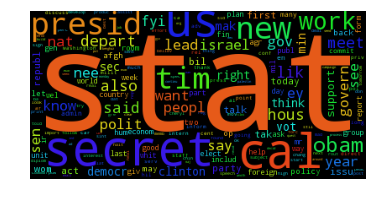

In [16]:
#Merging everything into one big chunk of text.
emails_str = ' '.join([' '.join(email) for email in email_text_processed_st])
wordcloud = WordCloud().generate(emails_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Here, we find roughly the same topics as above, but their *stemmed* versions. This is quite disturbing in the process of identifiying exactly which word would come down to each stemmed version, and is in our opinion, not the best way of visualising the content of the emails. There are also some strange associations that could me made, like, for instance, *secretary* and *secret*, which could end up having the same stemmed counterpart. Our preferred word cloud would be the second one, which seems to highlight quite efficiently the content of those emails.

# 02 - Finding the mentions of world countries
> Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

We first import all the countries and retrieve them in a list and will try to count the occurence of each country in each email. Note that as it is note easy to find a dictionary that contains the name of the inhabitants of each country (like *swiss* for *Switzerland* or *american* for the *United States*, we will work with the non-stemmed version of the text, as the stemming will not provide anything more (It only would have if we had the name of the inhabitants describing every country) : indeed, maybe *afghan* and *afghanistan* will reduce to the same stemmed version, but *american* and *United State* will certainly not. Considering the stemmed version would introduce a bias towards the countries which have the same stemmed name and inhabitants name. This is why we choose **NOT** to work with the stemmed version of the emails.

First of all, we load the countries, and store their lowercase version into a list.

In [17]:
import pycountry
countries = [country.name.lower() for country in list(pycountry.countries)]

Before properly discussing sentiment analysis, we just want to see which country are mention the most often in the emails, and plot a resulting histogram. We first below count the frequency of apparition of the name of the country in the emails, iterating over all of them. At the same time, we still perform sentiment analysis, but we will discuss it a bit later on. First below, we load the lexicon we need to detect whether a sentence is positive or not.

In [18]:
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Now, after posessing these dictionaries, we wanted to work directly with the`nltk` sentiment analysis methods, but their return types did not fit what we needed, we then chose to slightly rewrite their return types, in order to get what we needed. We rewrote the two main methods we're using, namely `demo_vader_instance` and `demo_liu_hu_lexicon`  The original code can be found on [this](http://www.nltk.org/_modules/nltk/sentiment/util.html#demo_vader_instance) page. We will discuss a bit later on which one we used and the motivation of our choice.

In [19]:
def demo_vader_instance(text):
    """
    Output polarity scores for a text using Vader approach.

    @param text: a text whose polarity has to be evaluated.
    @return vader_analyszer : the result of the analysis with Vader approach
    """
    from nltk.sentiment import SentimentIntensityAnalyzer
    vader_analyzer = SentimentIntensityAnalyzer()
    #print(vader_analyzer.polarity_scores(text))
    return vader_analyzer

def demo_liu_hu_lexicon(sentence,positive,negative,tokenizer):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    """

    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]
    pos = len([y for y in tokenized_sent if (len(y)>1) and (y in positive)])
    neg = len([y for y in tokenized_sent if (len(y)>1) and (y in negative)])

    return (pos>neg)-(neg>pos)

Before going further, let us just see a small example of the way each method works, and what type of result it returns.

In [20]:
# Extract a given email
str_ = ' '.join(email_text_processed[5])

# Print it and perform sentiment analysis
print(str_)
print("\nSubjectivity analysis: ",end="\t")
nltk.sentiment.util.demo_sent_subjectivity(str_)
print("Liu Hu lexicon :",end="\t")
nltk.sentiment.util.demo_liu_hu_lexicon(str_)
print("Vader Demo :", end="\t")
print(demo_vader_instance(str_).polarity_scores(str_))

pis print clintonernailcom wednesday september russorv state gov meet right wing extremist behind anti fvluslim film sparked deadly riots meat sent wednesday september subject meet right wing extremist behind anti muslim film sparked deadly riots htte maxbiumenthal meet right wing extremist behind anti musiim tihn sparked deadly riots sent verizon wireless lte droid u department state case f doc date state dept produced house select benghazi comm subject agreement sensitive information redactions foia waiver state

Subjectivity analysis: 	obj
Liu Hu lexicon :	Negative
Vader Demo :	{'neg': 0.195, 'neu': 0.767, 'compound': -0.9118, 'pos': 0.037}


We see that the classification is negative here, as the content of the email seems clearly negative. Note that we see here something that could be a problem for later on, in the fact that there are quite some spelling mistakes and abbreviations in the emails. Fixing this problem would require a way too large amount of time.

Then, in the next cell, we properly run sentiment analysis as well as finding the occurrence of every country in the emails. The `frequency` dictionary will store the frequency of each country, while the `pola` dict will store, the sum of the polarity (ranged from -1 to 1) for each email in which a given country appears. 

Note that we choose to use the Vader sentiment analyser as the Liu Hu one, which is often more precise, is also way slower, making the task nearly endless, even though there are only around 8000 email from which we extract the content. We ran both algorithms and will compare later on the results obtained from both algorithms.

We also only work at the precision of a **whole** email. This may lead to imprecise polarity classification of an email. Indeed, imaging the content is extremely positive, except around the mention of a country, where it is very negative. The total would still be positive, even if the country is mentionned negatively. The improvement could be to split the email by sentences, then perform sentiment analysis on each of them, and see the result for the surroundings of the sentence in which a country is mentionned. This would not be simple to implement, and we did not take the time to do it. We then will probably end up, due to this issue, having much more **positive rankings than negative ones**.

In [21]:
from nltk.corpus import opinion_lexicon
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import os


def sentimentAnalysis(email_text_processed, vader=True):
    frequency = {}
    pola = {}
    
    if vader:
        file = 'polarity_vader.csv'
    else:
        file = 'polarity_liu_hu.csv'
    if(os.path.isfile(file)):
        polarity_df = pd.read_csv(file)
        polarity_df.columns = ['Country','Polarity','Frequency']
        polarity_df = polarity_df.set_index('Country')
        frequency = polarity_df['Frequency'].to_dict()
        pola =  polarity_df['Polarity'].to_dict()
    else:
    
        positive = opinion_lexicon.positive()
        negative = opinion_lexicon.negative()
        if not vader:
            # Needed for another Sentiment Analysis Approach.
            tokenizer = treebank.TreebankWordTokenizer()

        print("Running sentiment analysis")
        for i,email in enumerate(email_text_processed):

            if i%100 ==0 :
                print(i,end=", ")
    
            #Reaggregating the list into one string of words.
            email_str = ' '.join(email)
            if vader:
                s = demo_vader_instance(email_str)
                polarity = s.polarity_scores(email_str)
    
                pos = polarity['pos']
                neg = polarity['neg']
                #Computing the polarity
            
                pol = 1*(pos>neg) - 1*(neg>pos)
            else :
                pol = demo_liu_hu_lexicon(email_str,positive,negative,tokenizer)
    
            #Assigning the values for each country.
            for country in countries:
                if country in email_str:
                    if country in frequency :
                        frequency[country] += 1                
                        pola[country] += pol
                    else:
                        frequency[country] = 1
                        pola[country] = pol

    return frequency, pola

## a) Sentiment Analysis with Vader 

In [22]:
frequency, pola = sentimentAnalysis(email_text_processed, vader=True)

After having computing the frequency of appearence of each country as well as its "cumulative" polarity, we need to rescale the polarity betweend -1 and 1 for it to be meaningful. We simply divide the polarity of a country by its frequency of appearance.

In [23]:
for country in countries:
    if country in frequency:
        pola[country] = pola[country]/frequency[country]

Then, we define a DataFrame `df_pola`, which stores the polarity as well as the frequency of appearance of each country.

In [24]:
df_pola = pd.DataFrame.from_dict(pola, orient='index')
df_pola = df_pola.rename(columns={0:"Polarity"}) 
df_pola['Frequency'] = df_pola.index.copy()
df_pola['Frequency'] = df_pola['Frequency'].map(frequency).astype(int)

df_pola = df_pola.sort_values(['Polarity'], ascending = False)
df_pola.head()

,Polarity,Frequency
turkmenistan,1.0,1
guyana,1.0,1
hungary,1.0,1
bahamas,1.0,1
suriname,1.0,1


We see already from displaying the head of `df_pola` that many countries appear only a very small number of times. Also, a lot of counrties are classified positively, due to the issue that we saw before. Let us focus on the countries that are mentionned negatively, i.e. that have a polarity smaller than 0.

In [25]:
df_pola[df_pola.Polarity <0]

,Polarity,Frequency
uganda,-1.000000e-14,10
serbia,-3.828280e-11,6
bermuda,-2.090752e-07,3
portugal,-2.090752e-07,3
chad,-6.103516e-05,2
south sudan,-1.220703e-04,2
maldives,-1.220703e-04,2
nauru,-1.000000e+00,1
malta,-1.000000e+00,1
united arab emirates,-1.000000e+00,1


We see that there are actually very few of them ! And that those mentionned negatively are not mentionned very frequently as well, in the exception of *Uganda* and *Serbia*. We will see below that the overwhelming majority of frequently mentionned countries are very positively mentionned, due to this bias of our algorithm.

Let us observe below the *Frequency* at which the countries are mentionned and the *Polarity of those countries*, both ranked. We only take countries that are mentionned more than 20 times, otherwise the plot would become overcrowded. Moreover, this helps us filter some non signficant events : we keep only the countries that are mentionned often, as the ones that are less mentionned are more likely to be wrongly classified, coming from the Sentiment Analysis of a single email, ...

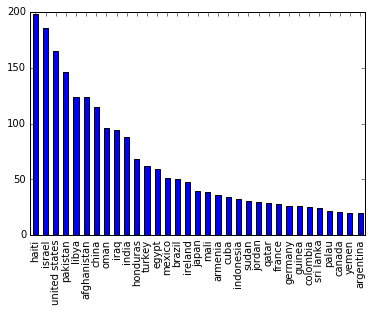

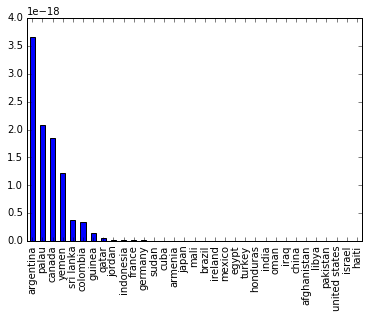

In [26]:
#
(df_pola[df_pola['Frequency'] >= 20])['Frequency'].sort_values(ascending=False).plot(kind='bar')
plt.show()

#Displaying the most appearing countries
(df_pola[df_pola['Frequency'] >= 20])['Polarity'].plot(kind='bar')
plt.show()

We see that the countries which are the most often talked about are : 
- Haiti
- Israel
- United States
- Pakistan
- Libya
- Afghanistan
Nothing too suprising, except maybe that thoes emails talk more about Haiti and Israel than the United States itself.

And if we take on the polarity ranking, the most *positively* mentionned countries (that are mentionned also more than 20 times) are *Indonesia* and *India*. The United States are mentioned positively as well, but are only around the tenth position. The countries that are seen in the most neutral way (close to zero) are *France*, *Yemen*, *Libya* and *Germany*. Note also finally, that there are no countries mentionned negatively due to this problem of considering the whole email.

There seems to be some significant differences between the countries mentionned positively and the country mentionned more neutrally. It does not seem to be linked to the frequency at which the countries appear, as *Libya*, which is neutral in Sentiment Analysis, is very often metnionned. But there are probably some significant differences, that we cannot see using our too simplistic approach.

Before moving on to the next topic, let us save the DataFrame for later reuse.

In [27]:
df_pola.to_csv('polarity_vader.csv')

## b) Sentiment Analysis with Liu Hu
Loading the results and normalising the polarity

In [28]:
frequency, pola = sentimentAnalysis(email_text_processed, vader=False)

for country in countries:
    if country in frequency:
        pola[country] = pola[country]/frequency[country]

Then, we define a DataFrame `df_pola`, which stores the polarity as well as the frequency of appearance of each country.

In [29]:
df_pola = pd.DataFrame.from_dict(pola, orient='index')
df_pola = df_pola.rename(columns={0:"Polarity"}) 
df_pola['Frequency'] = df_pola.index.copy()
df_pola['Frequency'] = df_pola['Frequency'].map(frequency).astype(int)

df_pola = df_pola.sort_values(['Polarity'], ascending = False)
df_pola.head()

,Polarity,Frequency
malta,1.0,1
turkmenistan,1.0,1
suriname,1.0,1
bahamas,1.0,1
samoa,1.0,1


We see already from displaying the head of `df_pola` that many countries appear only a very small number of times. Also, a lot of counrties are classified positively, due to the issue that we saw before. Let us focus on the countries that are mentionned negatively, i.e. that have a polarity smaller than 0.

In [30]:
df_pola[df_pola.Polarity <0]

,Polarity,Frequency
israel,-0.000058,186
libya,-0.000455,124
france,-0.001276,28
ireland,-0.002604,48
germany,-0.004438,26
yemen,-0.005000,20
poland,-0.006920,17
peru,-0.010000,10
kyrgyzstan,-0.015306,14
jamaica,-0.020408,7


Compared to the Vader algorithm, the Liu Hu algorithm finds more occurrences of negatively considered countries, and for countries that are more often represented, like *Israel* (which is more neutral than negative) and *Libya*. 


Let us observe below the *Frequency* at which the countries are mentionned and the *Polarity of those countries*, both ranked. We again take the countries with a frequency larger than 20.

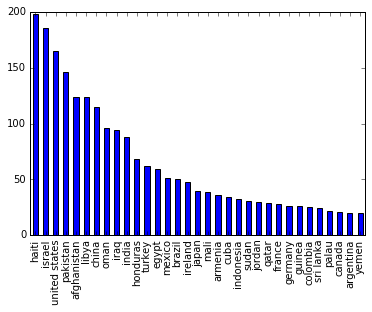

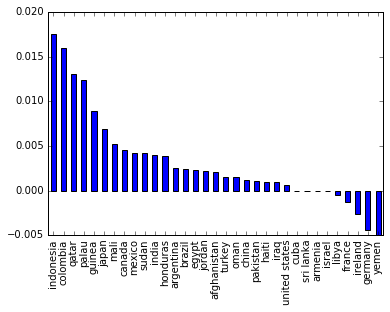

In [31]:
#Frequency plotb
(df_pola[df_pola['Frequency'] >= 20])['Frequency'].sort_values(ascending=False).plot(kind='bar')
plt.show()

#Displaying the most appearing countries
(df_pola[df_pola['Frequency'] >= 20])['Polarity'].plot(kind='bar')
plt.show()

The frequency of appearance obviously does not change, but the polarity does change a lot. We have a larger spectrum of values taken, and even some negative ones. Note that the ranking of the countries does not change a lot, the values that had a low polarity before still have a low polarity and so on. Some countries move, but not drastically. The countries which are less well perceived are the same as before, except that Ireland moved to the most negative country often present in the mails.

# 03 - Topic Modelling
> Using the `models.ldamodel` module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

First, we do an analogous processing to what was done in the Sentiment Analysis part, except we want to filter some more words, that do not bring much to the determination of a topic. We ran several times the topic modelling and tried to remove some words which made topics similar, but had no meaning, like common verbs, adverbs, ... that were not filtered from the stop words before. We also add the common words that do not help distinguishing between the clusters. Suprisingly, we also put words like Obama, president, government into it because these words appeared in every topic that we got from previous LDAs, so in order to obtain more distinct topics, we add them to the `stop_list`. And overall, this make a quite long stop list, but it contains words that are not linked to any specific topic, and that appeared everywhere.

In [32]:
new_stop_list = ['would','today','u','e','thx','said','see','new','one','mr','like','us','call','fyi','yet','also','work','time','get','want','like','w','en',
                 'get','talk', 'b', 'think','tomorrow','know','j','g','good','sent','qqdr','let', 'gov','com','case','two','year', 'back','going','need','next',
                 'last','still','go','best','sure','pls','clintonemail','could','may','mtg','week','way','come','take','well','hope','told','send','make','print',
                 'f','doc','state','states','ap','says','people','obama','president','government','many','secretary','clinton','even','first','fm','working',
                 'house','thanks','called','meet','pis','local','date','department','meeting','ok','yes','much','list','mail','email','hrc','schedule']

email_text_processed = [[word.lower() for word in email if word.lower() not in new_stop_list]
                        for email in email_text_processed]

from collections import defaultdict
frequency = defaultdict(int)
for email in email_text_processed:
    for token in email:
         frequency[token] += 1


emails = [[token for token in email if frequency[token] > 1]
         for email in email_text_processed]

Perform the LDA topic modelling and print the results. Note that here, we will not print the bag of most common words in order to compare them, but rather use the *pyLDAvis* library, which allows us to see in 2D how two clusters are close to each other (in terms of common words). We will then try to consider the number of topics which yields the more distinct clusters we can have. What we do below is perform topic modelling for a different number of topics, and store the resulting model in a list, which we will visualise later on.

In [33]:
dictionary = gensim.corpora.Dictionary(emails)
# Converts a collection of words to its bag of word representation (list of word_id, word_frequency 2-tuples$)
corpus = [dictionary.doc2bow(email) for email in emails]

num_topic =  [5,6,7,25,50]
ldamodel = []
for topic in num_topic :
    print("Considering",topic,"topics")
    ldamodel += [gensim.models.ldamodel.LdaModel(corpus,num_topics=topic,id2word = dictionary)]#, passes=1)


Considering 5 topics
Considering 6 topics
Considering 7 topics
Considering 15 topics
Considering 25 topics
Considering 50 topics


Below, there is an interactive visualisation of the similarity between the clusters, for 5,7,15 and 50 topics, to illustrate how they span the whole space of words, and how representative they are of it.

In [49]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldamodel[0], corpus, dictionary)
pyLDAvis.display(vis_data)

 Even though we only consider 5 topics, there is already a lot of overlap between all the clusters, due to the fact that the topic 2 is inside the topic one. This suggests three things :
1. The stop words list is not exhaustive enough, and we should remove even more words.
2. The topics are really similar.
3. The topics are not that similar, but the representation induces us a bit into error.

There is a bit of all 3 of them in this case, but let us focus more on the first and third clusters. Even if they have a lot of words in common, the most significant words are not the same ! For the first one, we have words like *israel*, *american*, *party*, *afghanistan*, *policy*. The third one has more words like *women*, *party*, *political*, *american*, *republican*, *united*. We see that even if there are some words in common, the topic do seem quite different, indeed, the first one seems to be more about international relations, while the second one seems to touch more on national politics. Even if they have a lot of words in common does not mean that they talk about the same things. The others topics are totally disjoint, which is very good.

Let us see now how the topic modelling performs with 6 topics.

In [35]:
vis_data = gensimvis.prepare(ldamodel[1], corpus, dictionary)
pyLDAvis.display(vis_data)

With 6 topics, the result is outstanding. All the topics are nearly disjoint (except one and four, which have a small overlap). They are very far apart in space and there are no clusters that seem to contain only a few words. 6 topics seems to be then a good contender for the best number of topics we can choose. We will try with 7 topics as well as 50 topics, just for the sake of seing what happens.

In [36]:
vis_data = gensimvis.prepare(ldamodel[2], corpus, dictionary)
pyLDAvis.display(vis_data)

Here, we have more distinct topics, but also the third topic ends up nearly totally in common with the first one. Also, the distance between the topics seems to have grown a bit smaller. Let us now try with 50 topics.

In [37]:
vis_data = gensimvis.prepare(ldamodel[4], corpus, dictionary)
pyLDAvis.display(vis_data)

The topics are totally spread an represent only a little part of the marginal topic distribution, while A LOT of topics are totally indistinguishable from each other. We then see that 6 topics seems a good choice of number, and will select it as our best topic modelling candidate. We will now try to compare it with the clusters we can make by doing community detection, working on the graph of communications rather than on all the emails at once.

# 04 - Communication graph
> BONUS: build the communication graph (unweighted and undirected) among the different email senders and recipients using the `NetworkX` library. Find communities in this graph with community.best_partition(G) method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

Let us load the `EmailReceivers.csv` file, which contains the recipients of the emails, and we will merge the `Id`,`SenderPersonId` columns of the `email_df` with the `receiver_df` to get our graph. Note that we will need to drop NaNs, as we can't keep an edge which only has one vertex determined. The `graph_df` below contains the *ReceiverId*, the *SenderId* and the email *Text.

In [38]:
receiver_df = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
receiver_df = receiver_df[['EmailId','PersonId']].set_index('EmailId')

graph_df = email_df[['Id','SenderPersonId','Text']]
graph_df = graph_df.set_index('Id')

graph_df = receiver_df.join(graph_df)
graph_df.dropna(inplace=True)
graph_df.columns = ['ReceiverId','SenderId','Text']
graph_df[['SenderId', 'ReceiverId']] = graph_df[['SenderId', 'ReceiverId']].astype(int)


graph_df.head()

,ReceiverId,SenderId,Text
1,80,87,
3,228,32,Thx
3,80,32,Thx
4,80,32,
5,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


We see that the IDs range from 4 to 513. 

In [39]:
print(graph_df[['ReceiverId','SenderId']].min())
print(graph_df[['ReceiverId','SenderId']].max())

ReceiverId    4
SenderId      5
dtype: int64
ReceiverId    513
SenderId      226
dtype: int64


Now we reuse the example that was given to us on the [community detection](http://perso.crans.org/aynaud/communities/index.html) page. This will allow us to retrieve the partition of the groups of senders and receivers and visualise the result.

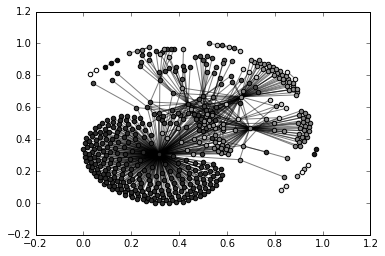

In [40]:
import community
import networkx as nx
import matplotlib.pyplot as plt

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = nx.from_pandas_dataframe(graph_df, 'SenderId', 'ReceiverId')
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()



There are some very large communities of emails, and also some isolated ones that we can easily see. Let us now analyze the partition that the algorithm returns. We define a DataFrame `persons_df` which simply maps each ID to its community. We will focus later on on the `SenderId`, as we were asked in the question.

In [41]:
persons = np.sort(pd.concat([graph_df['SenderId'], graph_df['ReceiverId']]).unique()).astype(int)
persons_df = pd.DataFrame({'Persons': persons})
persons_df['Partition'] = persons_df['Persons'].map(partition)

# Seeing how many people are in each partition
print(persons_df['Partition'].value_counts())

2     238
9      54
8      49
4      41
3      40
13     10
10      7
7       4
6       4
5       3
0       3
12      3
16      2
11      2
14      2
15      2
1       2
17      2
Name: Partition, dtype: int64


We see that there are 5-7 dominant partitions (communities), and 10-12 very small ones, of people exchanging email together mostly. The 5 major communities, are :
- 2 : 238 people
- 9 : 54 people
- 8 : 49 people
- 4 : 41 people
- 3 : 40 people

With also 13 (10 people) and 10 (7 people). The reste are very small (4-2 people).

Now, we map the `SenderId` to their community and split the emails by community. After that, we will output the 20 most common words of the senders of each community by tokenizing the dataset and removing the stop words once more. Below, we have the DataFrame which contains the `SenderID` and the text associated to it. We will simply merge the `sender_df` with the `persons_df` after.

In [42]:
sender_df = graph_df[['SenderId','Text']]
sender_df.head()

,SenderId,Text
1,87,
3,32,Thx
3,32,Thx
4,32,
5,80,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


Now merge the two DataFrame into `partition_df`, group by the `Partition` entry and sum the whole `Text` in each partition to end up with our `partition_text` DataFrame, which is a `Series`, the final object we'll work with.

In [43]:
partition_df = pd.merge(sender_df, persons_df, how='inner', left_on='SenderId', right_on='Persons')
partition_df.head()

partition_text = partition_df[['Partition','Text']].groupby('Partition')
partition_text = partition_text['Text'].apply(lambda x: " ".join(x)) 

partition_text

Partition
0                                                      
1                                                      
2     H <hrod17@clintonemail.com>\nFriday, March 11,...
3      FYI Fyi\nB6\n— — Fyi This is nice. Amazing.\n...
4     Anne-Marie Slaughter\nSunday, March 13, 2011 9...
5                                                      
6     My hair is getting whiter by the minute watchi...
7      Cc: Cheryl, Doug, Justin\nThere is a context ...
8     http://religion.b1ogs.cnn.com/20 1 2/09/13/my-...
9     Thx Thx   _ .....\nFrom Randolph, Lawrence M\n...
10    Madam Secretary, here is our latest draft of F...
11                                                     
12                                                     
13    Just e-mailed me to say he is at his hotel in ...
14    Gentlemen, for your information below.\nWerner...
15                                                     
16    Can you send me the complete NYT piece so that...
17                                    

Note that very surprisingly, some groups only have empty emails. These are probably due to the fact that the only thing they're exchanging are attached documents, which we ignore through our tokenizing and stop words. These also correspond to the smallest communities we had before, so it should not be, in the end, a problem.

Now, let us create a full stop list, which contains the default stop list as well as our stop list that we made for LDA just before. We will need to process the corpus of email (it is not that large, so the operation is quick, and go on finding the top word frequency for each community.

In [44]:
new_stop_list.extend(stop_list)

In [45]:
# Tokenize
partition_text_processed_token = [WordPunctTokenizer().tokenize(email) for email in partition_text]

# Lower letters + alphabetic characters only
partition_text_processed_token = [[word.lower() for word in email if word.isalpha()]
                        for email in partition_text_processed_token]

# Remove stop words.
partition_text_processed = [[word for word in email if word not in new_stop_list]
                        for email in partition_text_processed_token]

Now we simply need to count the frequency of each word in each sub corpus and pick the 20 most present ones.

In [46]:
frequency_partition = list()
# Count the occurrences of each word in each sub corpus.
for i,email in enumerate(partition_text_processed):
    frequency = defaultdict(int)
    for token in email:
         frequency[token] += 1
    frequency_partition.append(frequency)

# Establish the top 20 word frequency for each sub corpus.
top_20_freq = list()
for (i,frequency_email) in enumerate(frequency_partition):
    top_list = list()
    if frequency_email:
        for j,word in enumerate(sorted(frequency_email, key=frequency_email.get, reverse=True)):
            top_list.append(word)
            if j >= 20:
                break
        top_20_freq.append(top_list)
    else:
        top_20_freq.append(top_list)

We display the results for the most important communities, those which actually have email contents. We will compare it below with the topics that we get from Latent Dirichlet Allocation, in Topic Modelling, and try to establish a resemblance.

In [47]:
print("2:",top_20_freq[2])
print("9:",top_20_freq[9])
print("8:",top_20_freq[8])
print("4:",top_20_freq[4])
print("3:",top_20_freq[3])


print("13:",top_20_freq[13])
print("10:",top_20_freq[10])

2: ['monday', 'discuss', 'speech', 'officials', 'part', 'office', 'china', 'sunday', 'women', 'thank', 'find', 'bill', 'help', 'since', 'early', 'letter', 'hillary', 'national', 'thursday', 'try', 'great']
9: ['party', 'american', 'israel', 'political', 'policy', 'right', 'white', 'percent', 'republican', 'support', 'foreign', 'public', 'democrats', 'security', 'united', 'national', 'world', 'israeli', 'administration', 'election', 'former']
8: ['huma', 'abedin', 'abedinh', 'health', 'weiner', 'confirmed', 'draft', 'oscar', 'foreign', 'care', 'morning', 'speech', 'ops', 'august', 'office', 'sheet', 'saturday', 'jake', 'coming', 'asking', 'secure']
4: ['women', 'foreign', 'policy', 'afghanistan', 'security', 'world', 'support', 'administration', 'issues', 'washington', 'senate', 'bill', 'afghan', 'american', 'great', 'start', 'public', 'pakistan', 'issue', 'united', 'treaty']
3: ['united', 'agreement', 'benghazi', 'information', 'subject', 'security', 'sullivan', 'sensitive', 'dept', 'c

The aim now is to see whether we can match those 20 popular words of each category to the topics that were found from the Latent Dirichlet Allocation. We do this totally empirically, by seing to which category the word matches best. Some words are found a lot, and almost in every 20 popular words, so they are of no help for the classification. Note also that there are some names, that do not help as well, like Sid, Reuters, Holbrooke, ...

We display below the top 20 words of each topics, along with the percentage that they represent in the word distribution.

3 and 10 (same topics) -> 3 and 5

sullivan, jacob

In [48]:
for i, bag in enumerate(ldamodel[1].print_topics(num_words=20,num_topics = 50)):
    print("Cluster ", i, ": ", bag)

Cluster  0 :  (0, '0.007*"party" + 0.004*"percent" + 0.004*"republican" + 0.004*"women" + 0.004*"vote" + 0.003*"health" + 0.003*"part" + 0.003*"bill" + 0.003*"political" + 0.003*"republicans" + 0.003*"voters" + 0.003*"right" + 0.003*"democrats" + 0.003*"congress" + 0.003*"democratic" + 0.003*"care" + 0.002*"election" + 0.002*"policy" + 0.002*"tea" + 0.002*"world"')
Cluster  1 :  (1, '0.013*"office" + 0.008*"israel" + 0.006*"room" + 0.005*"israeli" + 0.005*"american" + 0.004*"conference" + 0.004*"private" + 0.004*"arrive" + 0.004*"route" + 0.004*"depart" + 0.004*"white" + 0.003*"peace" + 0.003*"staff" + 0.003*"boehner" + 0.003*"residence" + 0.003*"palestinian" + 0.003*"national" + 0.003*"daily" + 0.003*"foreign" + 0.003*"security"')
Cluster  2 :  (2, '0.005*"huma" + 0.005*"monday" + 0.004*"message" + 0.004*"please" + 0.004*"abedin" + 0.004*"wednesday" + 0.003*"office" + 0.003*"lona" + 0.003*"tuesday" + 0.003*"morning" + 0.003*"september" + 0.003*"cheryl" + 0.003*"cdm" + 0.003*"friday" +

We get the following matches (ranked from most convincing to less convincing) :

Community |People in the community| Cluster | Words in common                                                                 
----------|-----------------------|---------|---------------------------------------------------------------------------------
    13    |        10             |    1    | office, room, arrive, route, depart, private, residence, conference, daily, ... 
    4     |        41             |    4    | women, foreign, policy, afghanistan, senate, washington, ...                       
    9     |        54             |    0    | party, political, policy, right, percent, republican, democrats, election ...   
    9     |        54             |    1    | american, israel, israeli, white, foreign, security, national ...                    
    2     |        238            |    2    | monday, office,sunday, women, thank, ...                                        
    2     |        238            |    5    | discuss, china ,sunday, great, ...                                              
    8     |        49             |    2    | huma, abedin, morning, office, ...                                              
    3/10  |        40/7           |    3    | (united), security, world, ...                                                  
    
A few remarks about those results :

- Those results are not that conclusive, as there is a lot of overlap in the words used between the communities. Two of the topics are convincingly matches, but the rest of them are less distincted, and even have less words in common overall.
- Again, there is also the problem of having names, like Sullivan and Cheryl, Mills, ..., in both topic modelling and community detection. 
- There seems to be some separation in the communities relative to the topics that are treated, with the exception of communities 3 and 10, which have overall all their words in common.
- Note that as LDA is not deterministic, the communities might not be the same every time we run it, as for the community detection, it is deterministic, as it only rests on the network of recipient senders.  
- The community #13, which is quite small, is very well matches with cluster 1, talking about setting meetings probably.
- The community #4, which is a bit larger, seems to match quite well with some politics, both national and international. 
- The community #9, which is again a bit larger, is very split between two topics : local politics and election, along with security topics, also talking about Israel
- The community #2, which is by far the largest, is not that well matches with the topics from Topic Modelling. It is quite split and has a lot of common words into both matches : this shows that, if time allowed, we should probably refine a bit more our stop list, in order to get those common words (like the days of the week, ...) out, to see whether it allows to perform a better topic modelling, or if it is, on the contrary, an important feature by which we detect communities.
- The community #8 seems to talk about humanitary aid, but there is not really a convincing matching with any of our topics. 
- The last communities, #3 and #10, with 40 and 7 people, are not very well matched to the LDA topics, but it is very interesting to highlight that their top 20 most used words is almost the same, with at least half of the words in common between both. This would suggest that even if the two communities do not communicate between each other, they do have roughly the same subjects treated.

To conclude we see that we can match the topics with the communities up to a certain extent, and that some matching is really good, while some is very bad. This is really an empirical solution, as the LDA result will change a bit every time we run the algorithm, returning us slightly better / worse results. 